#4.3.2 농구선수의 게임 기록을 학습해서 포지션을 예측

In [1]:
import pickle

#피클(pickle) 데이터 불러오기 선택 변수
HDD = True # True : 하드디스크에서 불러오기, False : 구글 드라이브에서 불러오기

if HDD == True:
    from google.colab import files
    
    files.upload() # 학습데이터 불러오기

    #basketball_train.pkl 파일 읽어들이기
    with open('basketball_train.pkl','rb') as train_data:
        train = pickle.load(train_data)
else :
    #구글 드라이브로부터 파일 불러오기
    from google.colab import drive
    drive.mount('/gdrive', force_remount=True)

    #구글 드라이브의 파일 불러오기("내 드라이브"폴더 => /gdrive/My Drive/)
    with open('/gdrive/My Drive/Colab Notebooks/basketball_train.pkl','rb') as train_data:
        train = pickle.load(train_data)

Saving basketball_train.pkl to basketball_train.pkl


In [2]:
if HDD == True:
    files.upload() # 테스트 데이터 불러오기

    #basketball_test.pkl 파일 읽어들이기
    with open('basketball_test.pkl','rb') as test_data:
        test = pickle.load(test_data)
else :
    with open('/gdrive/My Drive/Colab Notebooks/basketball_test.pkl','rb') as test_data:
        test = pickle.load(test_data)

Saving basketball_test.pkl to basketball_test.pkl


##최적의 SVM 파라미터 찾기(C와 감마)


In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC #SVM중 분류(Classification)를 사용 -> SVC
                                           #참고로 SVM중 회귀(Regression)는 SVR로 임포트

# 서포트 벡터 머신 파라미터 선택 함수 선언 (사용자 정의 함수)
def svc_param_selection(X,y,nfolds):
    svm_parameters = [{'kernel' : ['rbf'], # 커널은 RBF 커널 사용 -> 커널 트릭을 사용
                                'gamma':[0.00001,0.0001,0.001,0.01,0.1,1], # 감마 범위 지정
                                'C':[0.01,0.1,1,10,100,1000]}] # C(비용) 범위 지정
    #사이킷런에서 제공하는 GridSearchCV를 사용해 최적의 파라미터를 찾음.
    clf = GridSearchCV(SVC(), svm_parameters, cv = nfolds) # nfolds : k 폴드 교차검증의 k값
    clf.fit(X,y) #최적의 C, 감마값 찾기
    print(clf.best_params_) #최적결과의 C, 감마, 커널 값 출력
    return clf

#3점슛과 블로킹 횟수를 학습 데이터로 사용
X_train = train[['3P','BLK']] #kNN에서는 '3P','BLK','TRB'를 사용했었음.
#농구선수 포지션을 예측값으로 선정
y_train = train[['Pos']]

#최적의 파라미터로 학습된 모델을 clf로 저장
clf = svc_param_selection(X_train,y_train.values.ravel(),10)# k 폴드 교차검증의 k를 10으로

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


##결정 경계선 시각화(최적 값을 바로 위에서 찾았으므로 꼭 할 필요 없음!!)

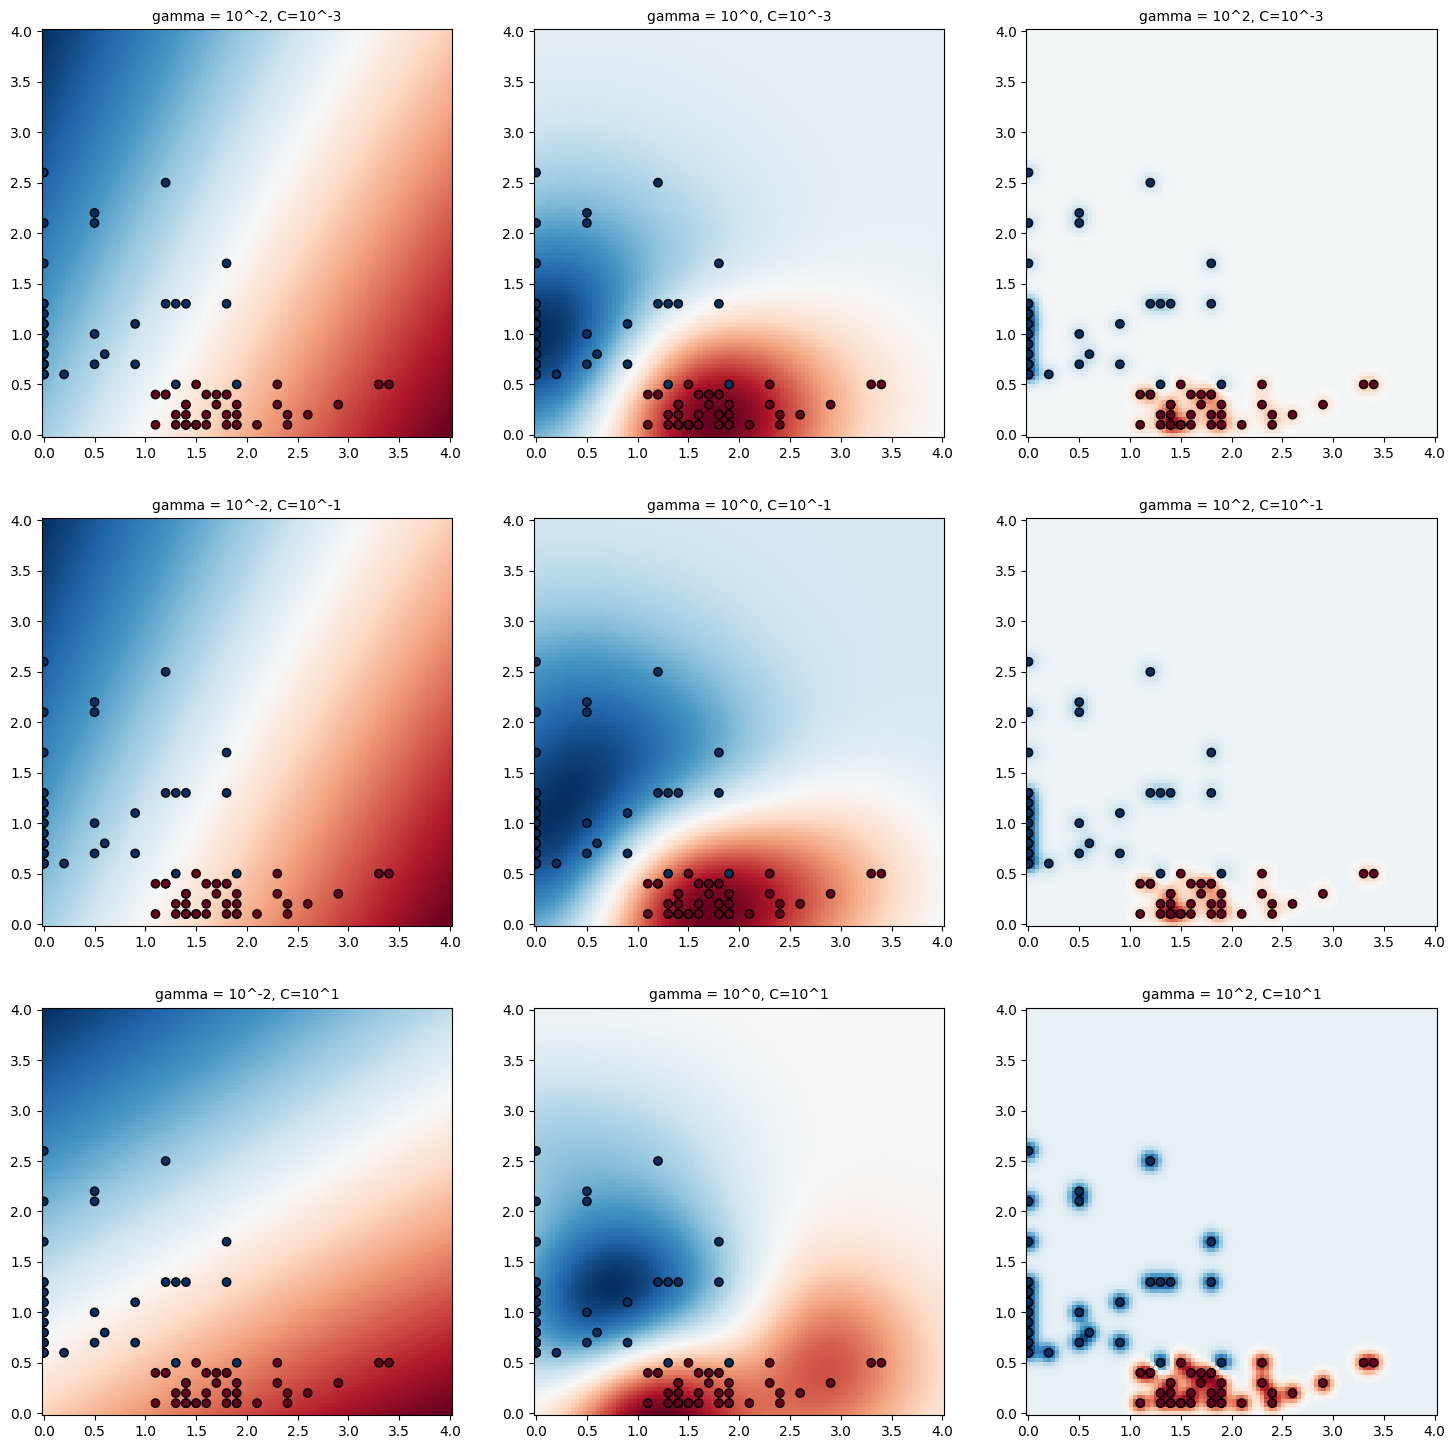

In [5]:
# import 문 추가하기 (교재에 없음)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 시각화를 하기 위해 최적의 C(비용)와, 최적의 C를 비교하기 위한 다른 C를 후보로 저장
C_candidates = []    # 리스트(배열) 선언
C_candidates.append(clf.best_params_['C'] * 0.01)    # 최적 C의 1/100배
C_candidates.append(clf.best_params_['C'])    # 최적의 C -> 위에서 0.1이었음.
C_candidates.append(clf.best_params_['C'] * 100)    # 최적 C의 100배

# 시각화를 하기 위해 최적의 gamma와, 최적의 gamma를 비교하기 위한 다른 gamma를 후보로 저장
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)    # 최적 gamma의 1/100배
gamma_candidates.append(clf.best_params_['gamma'])  # 최적의 감마 -> 위에서 1이었음.
gamma_candidates.append(clf.best_params_['gamma'] * 100)  # 최적 gamma의 100배

# 3점슛과 블로킹 횟수로 학습
X = train[['3P','BLK']]
# 농구선수 포지션을 학습 모듈의 분류값으로 사용
Y = train['Pos']    # 주의! 1차원 리스트(배열)임. 교재에서와 같이 .tolist() 사용 안 해도 됨.

# 시각화를 위해 센터(C)와 슈팅가드(SG)를 숫자로 표현
position = []
for gt in Y:   # for, if문 (들여쓰기 조심: 4칸, 8칸)
    if gt =='C':
        position.append(0)  # 센터인 경우 0으로 저장
    else :
        position.append(1)  # 슈팅가드인 경우 1로 저장

# 각각의 파라미터에 해당하는 SVM 모델을 실행하여 classifiers에 저장
classifiers = []
for C in C_candidates:      # 중첩 for문 (들여쓰기 조심: 4칸, 8칸)
    for gamma in gamma_candidates:
        clf_gp = SVC(C=C, gamma=gamma)# C와 gamma 값으로 SVM 설정
        clf_gp.fit(X.values,Y)# SVM 학습 실행
        classifiers.append((C,gamma,clf_gp))# C와 gamma, SVM 실행 결과를 classifiers에 저장

# 각 모델을 시각화        
plt.figure(figsize=(18,18))        # 전체 그림 크기 지정, 즉 18, 18 사이즈로 차트를 구성
xx, yy = np.meshgrid(np.linspace(0,4,100), np.linspace(0,4,100))
                                  # linspace(시작, 끝, 전체 점의 수). 스펠링 주의!! lin에 e가 없음.
# 위 문장 실행 후, xx = [[0, 0.04, 0.08, ... , 1, 1.04, ... , 2, ... , 3, ... , 4],
#                                [0, 0.04, 0.08, ... , 1, 1.04, ... , 2, ... , 3, ... , 4],
#                                                           .....................
#                                [0, 0.04, 0.08, ... , 1, 1.04, ... , 2, ... , 3, ... , 4]]  <= 100줄
#                       yy = [[     0,      0,      0, ... ,    0],
#                                [0.04, 0.04, 0.04, ... ,0.04],
#                                [0.08, 0.08, 0.08, ... ,0.08],
#                                          .....................
#                                [     4,      4,      4, ... ,    4]]   <= 100줄

# 각각의 모델들에 대한 결정 경계 함수를 적용하여 함께 시각화
for (k, (C,gamma,clf_gp)) in enumerate(classifiers):    # enumerate(a) : a의 각 경우를 k에 0부터 저장(아래 예 참조)
    Z = clf_gp.decision_function(np.c_[xx.ravel(), yy.ravel()]) # ravel() : 1차원 리스트(배열)로 만들기
    Z = Z.reshape(xx.shape)    # np.c_[ ] : [ ]의 두 요소 값으로 2차원 리스트 만들기
    # (예) for k, name in enumerate (['body', 'foo', 'bar']):
    #            print(k, name)
    #       ==> 실행 결과 : 0 body
    #                               1 foo
    #                               2 bar        
    # clf_gp.decision_function : clf의 값을 사용하여 경계면을 찾아내는 함수. 경계면이면 0, 한쪽 클래스는 음수,
    #                                    나머지 한쪽 클래스는 양수로 값을 출력함.
    # xx.shape : xx의 모양(여기서는 100x100)
    # Z.reshape(xx.shape) : Z를 (xx.shape)의 모양(즉, 여기서는 100x100)으로 2차원 리스트로 만들어줌. 
    #                                 이거를 하는 이유는 decision_function의 결과가 저장된 Z는 1차원 리스트로 저장되어 있음. 
    #                                 이거를 2차원 그래프로 나타내기 위해 reshape 명령을 사용해서 2차원 리스트로 만들어 주는 것임.
    
    # 최적의 모델을 포함한 다른 파라미터로 학습된 모델들을 함께 시각화
    plt.subplot(len(C_candidates), len(gamma_candidates),k+1)   # subplot(3,3,1) : 3x3 배열 중 첫 번째에 그리기
    plt.title("gamma = 10^%d, C=10^%d" % (np.log10(gamma),np.log10(C)),size = 'medium')
                                                    #예: log10(0.01) = log10(10^-2) = -2

    # 결정 경계영역과 결정경계선 그리기
    plt.pcolormesh(xx, yy, -Z, cmap = plt.cm.RdBu)  # xx와 yy 좌표에 대해 Z값으로 색상 그리기
    # cmap에서 지정한 색상에 따라 Z 값으로 색상을 그리는데, cmap이 Rd(Red), Bu(Blue) 순이므로 Z가 음수이면 빨간색,
    # 양수이면 파란색, 0이면 하얀색으로 색상을 그리게 됨. 그런데 이대로 그림을 그리면 색상이 반대로 표시되어 정상적으로 
    # 색상 표시를 하기 위해 Z에 마이너스를 붙인 것임.
    
    # 3점슛과 블로킹 값을 이용하여 센터와 슈팅가드 점 찍기
    plt.scatter(X['3P'], X['BLK'], c=position, cmap=plt.cm.RdBu_r,edgecolors='k') # edgecolors: 테두리 색, 'k'는 'Black'.
    # 3P(x축)와 BLK(y축)의 좌표에 c값에 따른 색상으로 점을 찍음. cmap에서 RdBu_r는 Rd(Red), Bu(Blue) 순서를 뒤집으란
    # 얘기임. 즉, 앞쪽이 Blue, 그 다음이 Red가 됨. 그런데 c 값이 위에서 센터는 0, 슈팅가드는 1로 지정되어 있으므로,
    # 결국 센터는 파란색 점으로, 슈팅가드는 빨간색 점으로 찍히게 됨.

# => AttributeError: 'SVC' object has no attribute 'best_params_'라는 에러 메시지가 뜨면
# => "런타임 > 모두 실행" 또는 Ctrl+F9을 눌러 처음부터 다시 실행할 것. 